## REFIT Dataset

In [343]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
plt.rcParams['figure.figsize'] = (25, 15)
plt.rcParams.update({'font.size': 22})

In [236]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [237]:
from keras.metrics import RootMeanSquaredError

In [302]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.callbacks import EarlyStopping


In [239]:
path="/Users/daniel.bustillo/Documents/thesis/REFIT"
os.chdir(path)

In [323]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [240]:
# list_of_names= []
# list_of_names=os.listdir(path)


  
# # create empty list
# dataframes_list = []
  
# # append datasets into teh list
# for i in range(len(list_of_names)):
#     temp_df = pd.read_csv(list_of_names[i], parse_dates=True, index_col=0, infer_datetime_format=True)
#     dataframes_list.append(temp_df)
# dataframes_list = [df.resample("1H").mean() for df in dataframes_list]
# dataframes_list = [df.drop(['Unix','Issues'], axis=1) for df in dataframes_list]

# dataframes_list = [i.loc[:,"Aggregate"] for i in dataframes_list]
    
# refit= pd.concat(dataframes_list, axis=1)
# refit.columns = np.arange(len(refit.columns))
# refit= refit.add_prefix("house_")


# refit= refit.loc[refit.index >"07-03-2014"].copy()


# # refit= refit.loc[refit.index<="05-01-2015"].copy()
# # refit.to_csv("refit_all.csv")

In [270]:
refit= pd.read_csv("refit_all.csv", parse_dates=True, index_col=0)

## EDA and Plots

In [243]:
refit1 = refit.copy()
refit1['hour'] = refit1.index.hour
refit1['weekday'] = refit1.index.weekday
avg= refit1.groupby(['hour','weekday']).mean()['house_10']
avg = avg.reset_index()
avg_pivot= avg.pivot("hour","weekday","house_10")
avg_pivot.columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

Text(0.5, 1.0, 'Average weekly electricity consumption in House 10 (in Watts)')

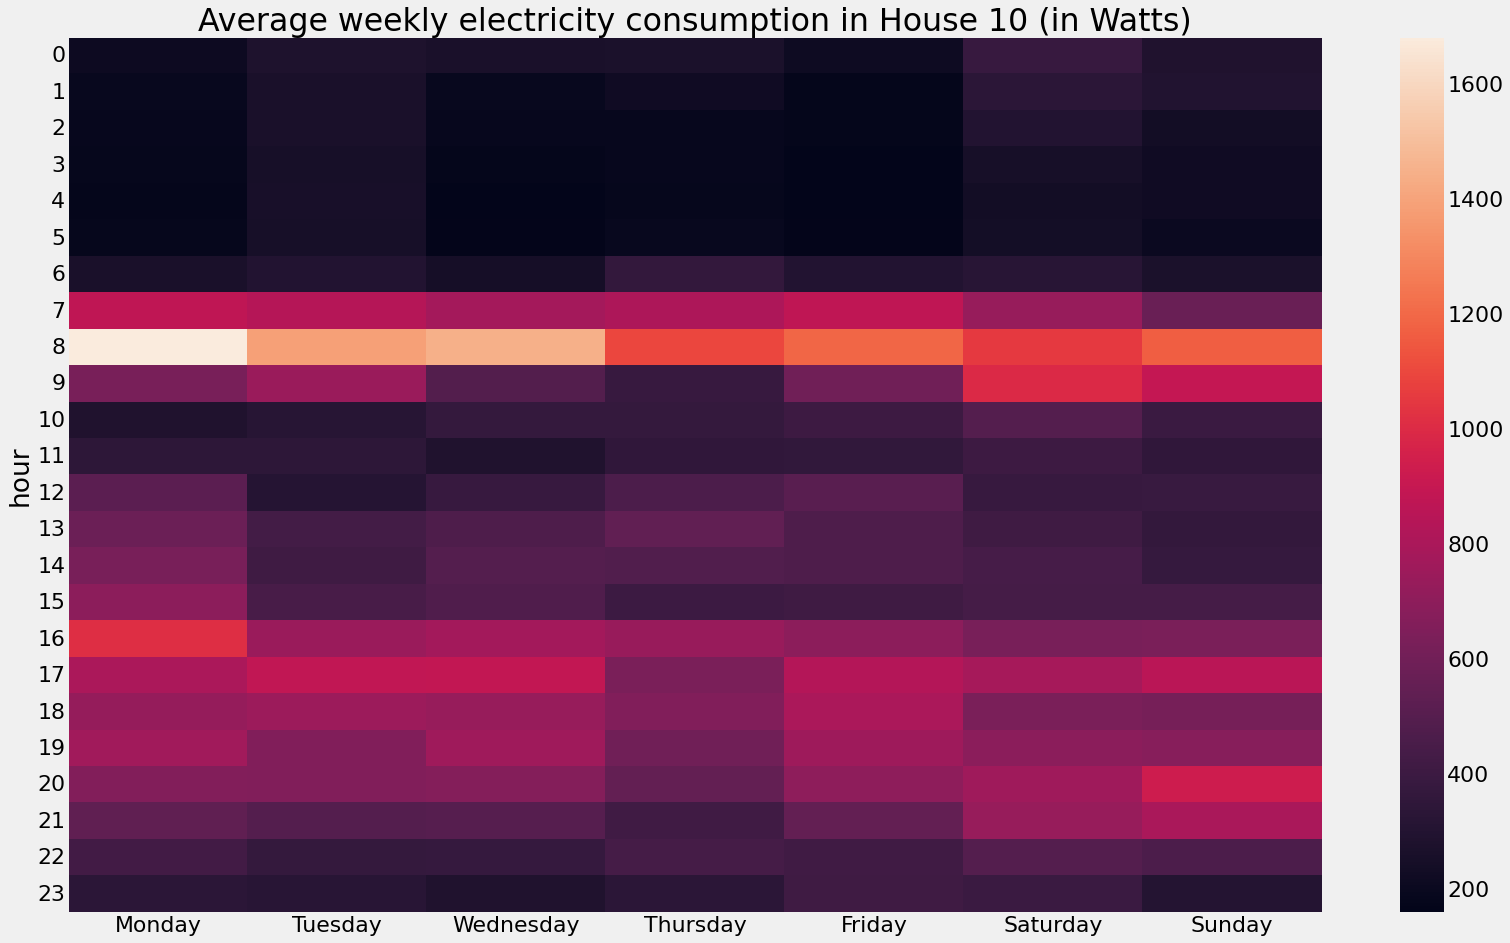

In [244]:
g=sns.heatmap(avg_pivot)

locs, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.title("Average weekly electricity consumption in House 10 (in Watts)")

<Figure size 1800x1080 with 0 Axes>

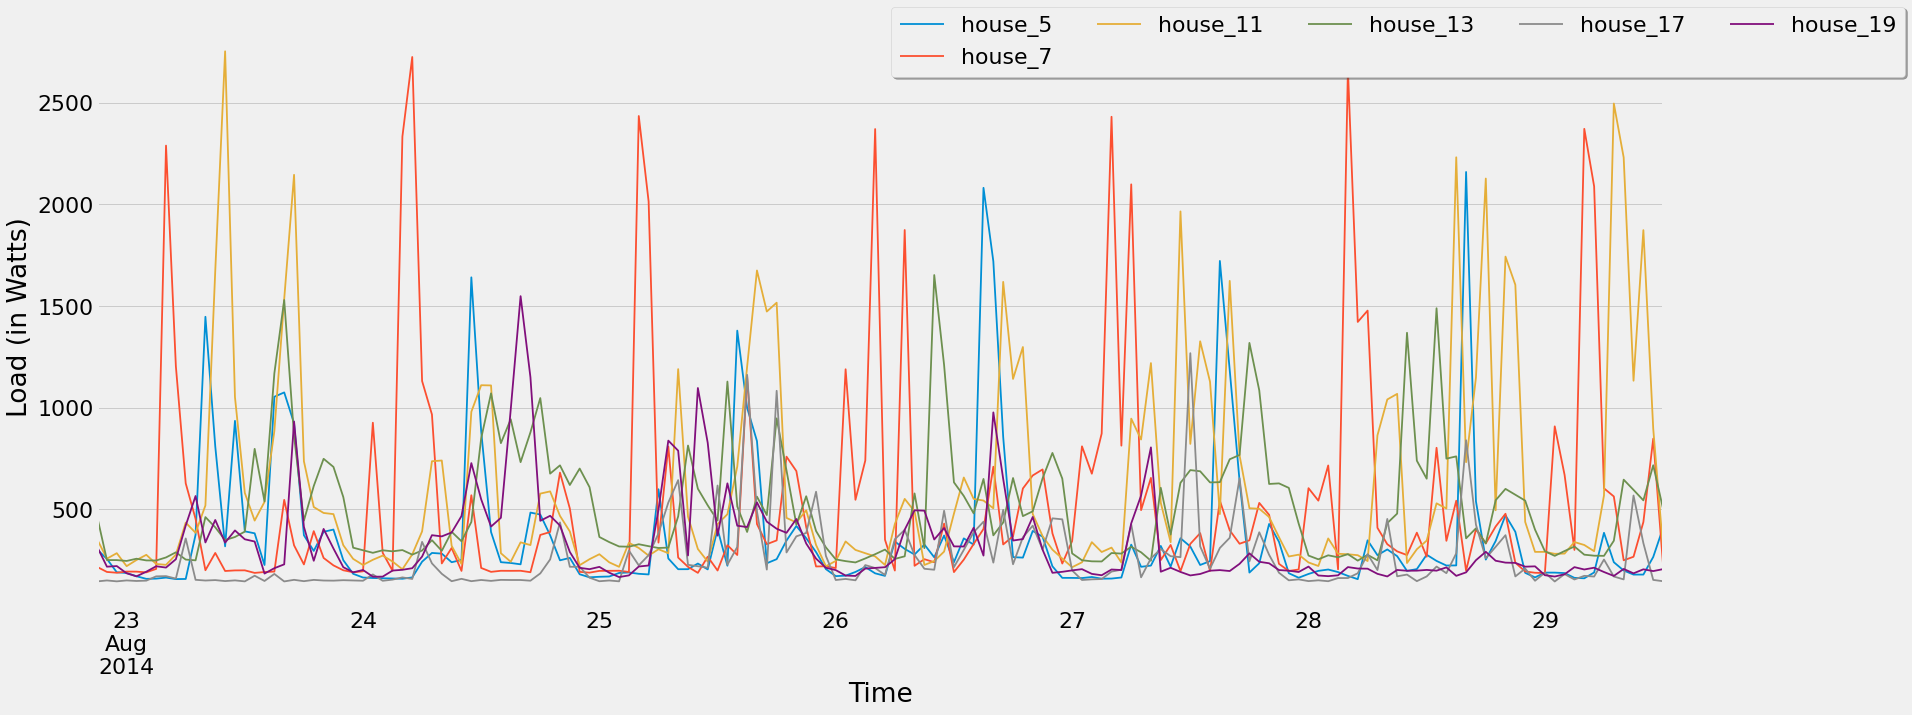

In [246]:
plt.figure()
plt.rcParams.update({'font.size': 22})
refit1.iloc[1220:1380,[5,7,11,13,17,19]].plot(subplots=False,lw=1.8, 
ylabel="Load (in Watts)", figsize=(25,10))
plt.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)


In [271]:
refit=refit.interpolate(method='time', axis=0)

In [272]:
for home in refit:
    q_99 = refit[home].quantile(0.90)

    refit[home] = np.where(refit[home]>=q_99, q_99, refit[home])



In [77]:
def create_features(df):
    """
    Creates time series features from datetime index.
    """
    # df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['night']= np.where((df['hour']>=18)|(df['hour']<6),1,0)
    df['lag_hour'] = df['Aggregate'].shift(periods=1)
    df['lag_day'] = df['Aggregate'].shift(periods=24)
    df['lag_week'] = df['Aggregate'].shift(periods=168)


# Univariate Benchmark example

In [273]:
    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error
    
    def mape(y_true, y_score):
        error = mean_absolute_percentage_error(y_true, y_score)
        return error

In [274]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [11]:
pred_train = {}
pred_test = {}

rmse_train={}
rmse_test = {}

mape_train = {}
mape_test = {}

In [275]:
def run_model(home: pd.Series, train_size, timesteps= 1, epochs=50, batch_size= 64, plot=False):
    """function that wraps all the processes of data preparation and model configuration"""
    print(home.name)
    #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

    #Define the model
    model = Sequential()
    model.add(LSTM(256))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

    #Fit the data
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    




    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"simple_lstm_{home.name}"] = scaler.inverse_transform(
                                model.predict(X_train,verbose=0)).flatten()

    pred_test[f'simple_lstm_{home.name}'] = scaler.inverse_transform(model.predict(X_test)).flatten()

    if plot ==True:

        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        #plot the predictions
        plt.plot(pred_test[f'true_{home.name}'])
        plt.plot(pred_test[f'simple_lstm_{home.name}'])
        plt.show()
    else:
        pass


    rmse_test[f'single_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    rmse_train[f'single_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

    mape_test[f'single_{home.name}'] = mape(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    mape_train[f'single_{home.name}'] = mape(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'single_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'single_{home.name}']}")




    


    

In [276]:
def run_conv_model(home: pd.Series, train_size, timesteps= 1, n_features=1, epochs=50, batch_size= 64, plot=False):
    """function that wraps all the processes of data preparation and model configuration"""
    print(home.name)
    #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

   

    conv = Sequential()
    conv.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, n_features)))
    conv.add(MaxPooling1D(pool_size=1))
    conv.add(Flatten())
    conv.add(Dense(50, activation='relu'))
    conv.add(Dense(1))
    conv.compile(optimizer='adam', loss='mse')

    #Fit the data
    history= conv.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    

    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"convlstm_{home.name}"] = scaler.inverse_transform(
                                conv.predict(X_train,verbose=0)).flatten()

    pred_test[f'convlstm_{home.name}'] = scaler.inverse_transform(conv.predict(X_test)).flatten()

    if plot==True:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        #plot the predictions
        plt.plot(pred_test[f'true_{home.name}'])
        plt.plot(pred_test[f'convlstm_{home.name}'])
        plt.show()
    else:
        pass


    rmse_test[f'conv_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'convlstm_{home.name}'])
    rmse_train[f'conv_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'convlstm_{home.name}'])

    mape_test[f'conv_{home.name}'] = mape(pred_test[f'true_{home.name}'], pred_test[f'convlstm_{home.name}'])
    mape_train[f'conv_{home.name}'] = mape(pred_train[f'true_{home.name}'], pred_train[f'convlstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'conv_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'conv_{home.name}']}")



    


    

# Hyperparameter Tuning

In [14]:
#install the package
import keras_tuner as kt
import keras.optimizers


In [17]:
def build_model(hp):
  model = Sequential()
  model.add(LSTM(hp.Choice('units',[24,64,128,256,512])))
  model.add(Dense(1, activation='relu'))
  model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate',[0.0001,0.001,0.01])), metrics=['mean_squared_error'])

  
  return model

In [18]:
tuner = kt.RandomSearch(
    build_model,
    objective= 'val_mean_squared_error',
    max_trials=20,
    executions_per_trial= 2,
    overwrite=True)

In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 24, 'conditions': [], 'values': [24, 64, 128, 256, 512], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [21]:
timesteps=1

In [22]:
home= refit['house_0']
home= home.dropna()


# train, test split
# split into train and test sets
values = home.values
values= values.reshape(len(values),1)
train, test = train_test_split(values, train_size=0.9, shuffle=False)

# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)


# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [23]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 12 Complete [00h 01m 11s]
val_mean_squared_error: 0.02664312720298767

Best val_mean_squared_error So Far: 0.026421750895678997
Total elapsed time: 00h 06m 32s
INFO:tensorflow:Oracle triggered exit


In [32]:
tuner.results_summary()
# Trial summary
# Hyperparameters:
# units: 256
# learning_rate: 0.01
# Score: 0.026421750895678997

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.01
Score: 0.026421750895678997
Trial summary
Hyperparameters:
units: 24
learning_rate: 0.001
Score: 0.026553609408438206
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.001
Score: 0.026569959707558155
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.0001
Score: 0.02664312720298767
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.01
Score: 0.03919405769556761
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.01
Score: 0.039217736572027206
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.001
Score: 0.0392885310575366
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.001
Score: 0.039299204014241695
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.0001
Score: 0.039354972541332245
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.001
Score: 0.03935842588543892


# Naive Multivariate LSTM approach

In [317]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [318]:
values= refit.values
values = values.astype('float32')

In [319]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [320]:
refithomes = {}

for j in range (20,40):
    refithomes[reframed.iloc[:,j].name] = reframed.iloc[:,np.r_[0:19,j]]

In [324]:
def train_multi_model(df, train_size = 0.9, neurons = 256, epochs=50, batch_size=168):
    '''function that takes a cleaned version of the modified dataframe, transforms the data into 
    [Samples, timesteps, features] , splits it into training and testing data, and trains a model on the 
    fitted data to then predict the test data and calculate the root mean square'''
    #Drop nan values
    df= df.dropna()
    # train, test split
    # split into train and test sets
    values = df.values
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=["mean_squared_error", "mean_absolute_error"])


    # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False,
    callbacks=[callback])


    #Predict on both sets
    yhat_test= model.predict(X_test)
    yhat_train = model.predict(X_train)

    #Reshape them to fit the right format to inverse_transform
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2]))

    inv_yhat_test= np.concatenate((X_test, yhat_test), axis=1)
    inv_yhat_train=np.concatenate((X_train, yhat_train), axis=1)

    inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)

    multi_test_pred= inv_yhat_test[:,-1]
    multi_train_pred = inv_yhat_train[:,-1]

    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    y_train = y_train.reshape(len(y_train),1)

    inv_y_test= np.concatenate((X_test, y_test), axis=1)
    inv_y_train= np.concatenate((X_train, y_train), axis=1)

    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_train = scaler.inverse_transform(inv_y_train)

    multi_test_true= inv_y_test[:,-1]
    multi_train_true = inv_y_train[:,-1]


    multi_rmse_test= rmse(inv_y_test, inv_yhat_test)
    multi_rmse_train = rmse(inv_y_train, inv_yhat_train)

    multi_mape_test= mape(inv_y_test, inv_yhat_test)
    multi_mape_train = mape(inv_y_train, inv_yhat_train)

    #multi_test = pd.DataFrame(multi_test)


    #multi_test.plot()

    return multi_train_pred, multi_test_pred,multi_train_true, multi_test_true,multi_rmse_train,multi_rmse_test, multi_mape_train, multi_mape_test

    
    

    

    
    

In [281]:
multi_train ={}
multi_test ={}

multi_rmse_train = {}
multi_rmse_test = {}

multi_mape_train ={}
multi_mape_test = {}

In [325]:
for key, value in refithomes.items():
    multi_train_pred, multi_test_pred,multi_train_true, multi_test_true,multi_error_train,multi_error_test, multi_mape1_train, multi_mape1_test = train_multi_model(value, epochs=50)
    multi_train[f"true_{key}"] = multi_train_true
    multi_train[f"multi_{key}"] = multi_train_pred

    multi_test[f"true_{key}"] = multi_test_true
    multi_test[f"multi_{key}"] = multi_test_pred

    multi_rmse_test[f"multi_{key}"] = multi_error_test
    multi_rmse_train[f"multi_{key}"] = multi_error_train

    multi_mape_train[f"multi_{key}"] = multi_mape1_train
    multi_mape_test[f"multi_{key}"] = multi_mape1_test

(6522, 1, 19) (6522,) (725, 1, 19) (725,)
Epoch 1/50
39/39 - 4s - loss: 0.0890 - mean_squared_error: 0.0890 - mean_absolute_error: 0.2358 - 4s/epoch - 105ms/step
Epoch 2/50
39/39 - 1s - loss: 0.0683 - mean_squared_error: 0.0683 - mean_absolute_error: 0.1969 - 1s/epoch - 28ms/step
Epoch 3/50
39/39 - 1s - loss: 0.0656 - mean_squared_error: 0.0656 - mean_absolute_error: 0.1880 - 600ms/epoch - 15ms/step
Epoch 4/50
39/39 - 1s - loss: 0.0646 - mean_squared_error: 0.0646 - mean_absolute_error: 0.1870 - 585ms/epoch - 15ms/step
Epoch 5/50
39/39 - 1s - loss: 0.0645 - mean_squared_error: 0.0645 - mean_absolute_error: 0.1867 - 560ms/epoch - 14ms/step
Epoch 6/50
39/39 - 1s - loss: 0.0644 - mean_squared_error: 0.0644 - mean_absolute_error: 0.1863 - 545ms/epoch - 14ms/step
Epoch 7/50
39/39 - 1s - loss: 0.0642 - mean_squared_error: 0.0642 - mean_absolute_error: 0.1860 - 651ms/epoch - 17ms/step
Epoch 8/50
39/39 - 1s - loss: 0.0641 - mean_squared_error: 0.0641 - mean_absolute_error: 0.1858 - 662ms/epoch

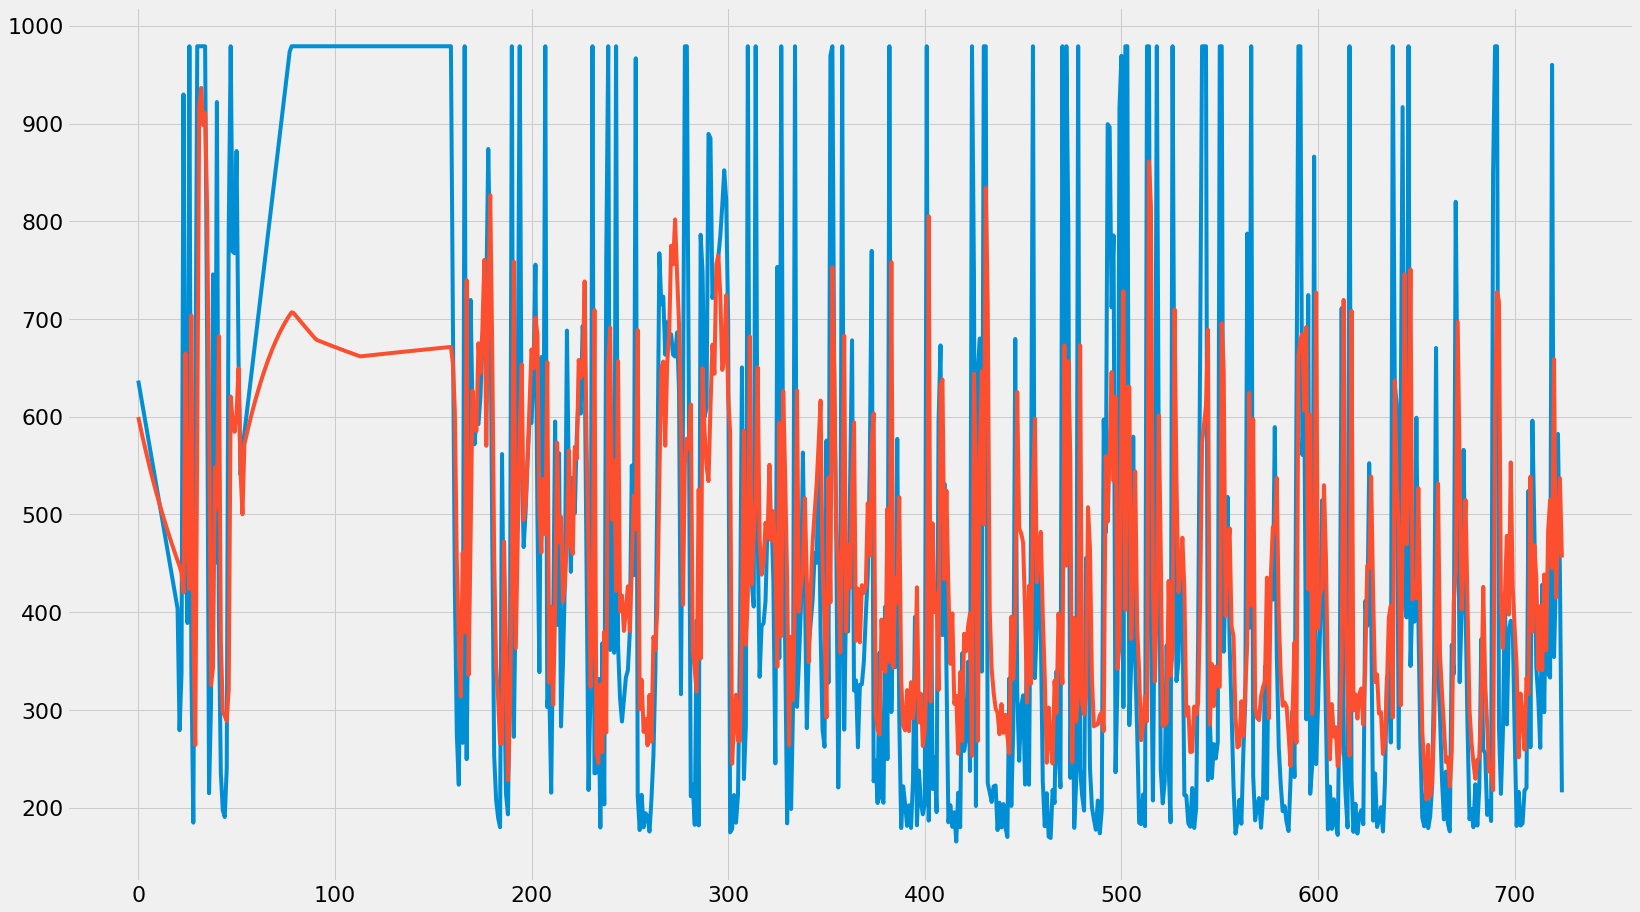

In [326]:
plt.plot(multi_test['true_home_10(t)'])
plt.plot(multi_test['multi_home_10(t)'])

In [327]:
pd.DataFrame.from_dict(multi_rmse_test, orient='index').to_csv("multi_results1.csv")
#multi_results1.csv: trained with no missing data

In [328]:
pd.DataFrame.from_dict(multi_mape_test, orient='index').to_csv("multi_mape1.csv")

# Federated version

In [288]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_percentage_error

In [289]:
class SimpleLSTM:
    @staticmethod
    def build(neurons, timesteps =1, n_features=1):
        model = Sequential()
        model.add(LSTM(neurons, input_shape =(timesteps,n_features)))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])
        
        
        return model

In [290]:
def weight_scalling_factor(clients_trn_data, client_name):
    #client_names = list(homes.columns())
    #get the bs
    #bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clients
    global_count = sum([len(clients_trn_data[client_name].dropna()) for client_name in client_names])
    # get the total number of data points held by a client
    local_count = len(clients_trn_data[client_name].dropna())
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

def mape(y_true,y_score):
    error = mean_absolute_percentage_error(y_true, y_score)
    return error
    
def test_model(X_test, Y_test,  model, comm_round, home):
    preds= model.predict(X_test)
    loss = rmse(Y_test, preds)
    scaled_preds = scaler.inverse_transform(preds)
    scaled_loss = rmse(scaler.inverse_transform(Y_test), scaled_preds)
    print('comm_round: {} |loss_in_{}: {} | scaled_loss_in_{}: {}'.format(comm_round,home,loss, home, scaled_loss))
    return loss, scaled_loss, preds, scaled_preds

In [291]:
def prepare_task(home: pd.Series, train_size= 0.9, timesteps= 1):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    #print(X_train.shape)

    return X_train, y_train, X_test, y_test, scaler


In [292]:
comms_round = 30
    
#create optimizer
lr = 0.01 
loss='mean_squared_error'
metrics = ['mse']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 



In [293]:
client_names = refit.columns

In [294]:
#initialize global model
smlp_global = SimpleLSTM()
global_model = smlp_global.build(256, 1, 1)
        


In [145]:

# pred_train={}
# pred_test= {}

# rmse_train={}
# rmse_test={}

# mape_train ={}
# mape_test ={}


In [298]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for house in refit:
        smlp_local = SimpleLSTM()
        local_model = smlp_local.build(256)
        local_model.compile(loss=loss, 
                        optimizer="adam", #Trying out adam
                        metrics=metrics)
        
        
    #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        #scaler = MinMaxScaler(feature_range=(0, 1))
        X_train, y_train, X_test, y_test, scaler= prepare_task(refit[house])


        local_model.fit(X_train, y_train, epochs=5, verbose=0, batch_size=64, callbacks=[callback])
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(refit, house)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        local_loss, scaled_loss, preds, scaled_preds = test_model(X_test, y_test, global_model, comm_round, house)

        pred_train[f"true_{house}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
        pred_test[f"true_{house}"]  = scaler.inverse_transform(y_test).flatten() 

        pred_train[f"fed_{house}"] = scaler.inverse_transform(
                                    local_model.predict(X_train)).flatten()

        pred_test[f"fed_{house}"] = scaler.inverse_transform(local_model.predict(X_test)).flatten()

        rmse_test[f'fed_{house}'] = rmse(pred_test[f'true_{house}'], pred_test[f'fed_{house}'])
        rmse_train[f'fed_{house}'] = rmse(pred_train[f'true_{house}'], pred_train[f'fed_{house}'])

        mape_train[f'fed_{house}'] = mape(pred_train[f'true_{house}'], pred_train[f'fed_{house}'])
        mape_test[f'fed_{house}'] = mape(pred_test[f'true_{house}'], pred_test[f'fed_{house}'])

        # #plot the predictions
        # plt.plot(pred_test[f'true_{home}'])
        # plt.plot(pred_test[f'simple_lstm_{home}'])
        # plt.show()

        K.clear_session()
    
            
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
  

comm_round: 0 |loss_in_house_0: 0.40534741536554003 | scaled_loss_in_house_0: 291.6789971245939
comm_round: 0 |loss_in_house_1: 0.3666886206507777 | scaled_loss_in_house_1: 494.7679320391389
comm_round: 0 |loss_in_house_2: 0.6327748854323129 | scaled_loss_in_house_2: 649.9907102736662
comm_round: 0 |loss_in_house_3: 0.4599175546142265 | scaled_loss_in_house_3: 606.9292676355444
comm_round: 0 |loss_in_house_4: 0.3118546418378876 | scaled_loss_in_house_4: 76.06161817858049
comm_round: 0 |loss_in_house_5: 0.39947866303622526 | scaled_loss_in_house_5: 394.11919287558317
comm_round: 0 |loss_in_house_6: 0.27646955406336327 | scaled_loss_in_house_6: 236.91681058219646
comm_round: 0 |loss_in_house_7: 0.4073175444130983 | scaled_loss_in_house_7: 501.07558422378384
comm_round: 0 |loss_in_house_8: 0.41291026927122504 | scaled_loss_in_house_8: 557.3474195835489
comm_round: 0 |loss_in_house_9: 0.5575342196637166 | scaled_loss_in_house_9: 461.1069472566332
comm_round: 0 |loss_in_house_10: 0.45485032

In [299]:
pd.DataFrame.from_dict(rmse_test, orient='index').to_csv("results3.csv")

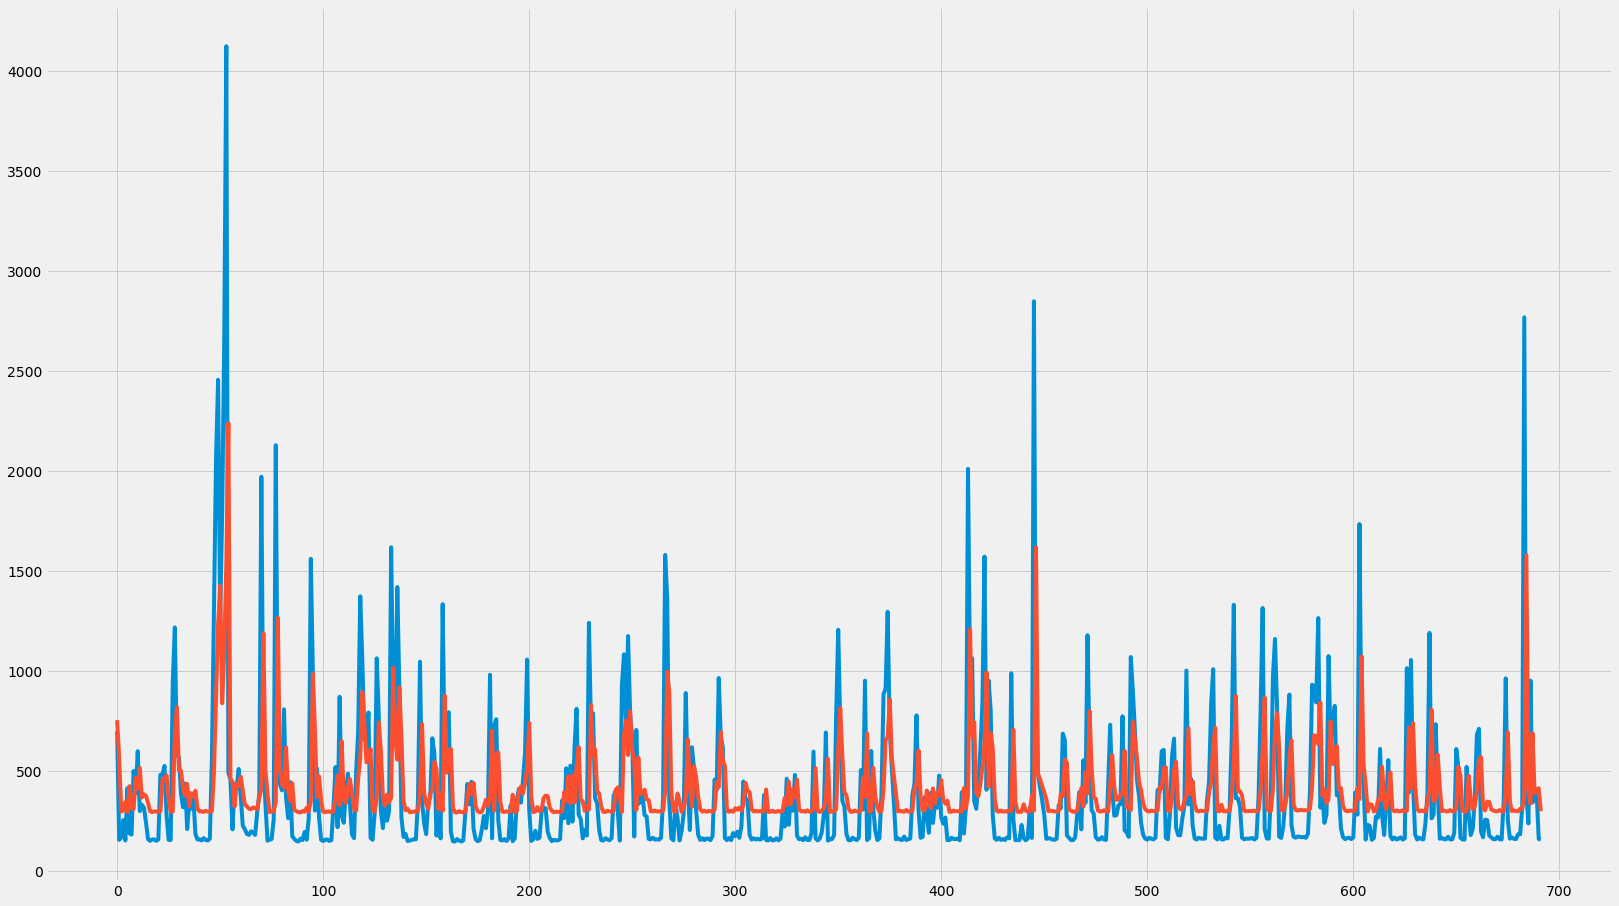

In [214]:
plt.plot(pred_test['true_house_0'])
plt.plot(pred_test['fed_house_0'])
# plt.plot(pred_test['simple_lstm_house_0'])
# plt.plot(pred_test['convlstm_house_0'])

# Training of the models

In [277]:
for home in refit:
    run_model(refit[home], train_size=0.9, epochs=50, batch_size=64)

house_0
(6522, 1, 1)
Epoch 1/50
102/102 [==============================] - 3s 10ms/step - loss: 0.0873 - mse: 0.0873 - val_loss: 0.0669 - val_mse: 0.0669
Epoch 2/50
102/102 [==============================] - 1s 6ms/step - loss: 0.0696 - mse: 0.0696 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 3/50
102/102 [==============================] - 1s 6ms/step - loss: 0.0694 - mse: 0.0694 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 4/50
102/102 [==============================] - 1s 7ms/step - loss: 0.0694 - mse: 0.0694 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 5/50
102/102 [==============================] - 1s 10ms/step - loss: 0.0693 - mse: 0.0693 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 6/50
102/102 [==============================] - 1s 11ms/step - loss: 0.0693 - mse: 0.0693 - val_loss: 0.0664 - val_mse: 0.0664
Epoch 7/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0693 - mse: 0.0693 - val_loss: 0.0664 - val_mse: 0.0664
Epoch 8/50
102/102 [==============================] 

In [278]:
for home in refit:
    run_conv_model(refit[home], train_size=0.9, epochs=50, batch_size=64)

house_0
(6522, 1, 1)
Epoch 1/50
102/102 [==============================] - 1s 3ms/step - loss: 0.0826 - val_loss: 0.0661
Epoch 2/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0689 - val_loss: 0.0656
Epoch 3/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0687 - val_loss: 0.0652
Epoch 4/50
102/102 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0650
Epoch 5/50
102/102 [==============================] - 0s 4ms/step - loss: 0.0685 - val_loss: 0.0648
Epoch 6/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0685 - val_loss: 0.0646
Epoch 7/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0684 - val_loss: 0.0645
Epoch 8/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0684 - val_loss: 0.0644
Epoch 9/50
102/102 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0645
Epoch 10/50
102/102 [==============================] - 0s 2ms/step - loss: 0.06

In [217]:
pd.DataFrame.from_dict(rmse_test,orient='index').to_csv("allresults2.csv")

#allresults.csv trained with 50 comm rounds, 50 epochs 
#allresults2.csv trained with 50 comm rounds(5 epochs each), 50 epochs (0.9 train_test_split)

In [300]:
pd.DataFrame.from_dict(mape_test,orient='index').to_csv("mape_fed.csv")

In [329]:
predictions= pd.DataFrame.from_dict(pred_test, orient="index")
predictions = predictions.T

In [330]:
pred16= predictions[['true_house_16',"fed_house_16","simple_lstm_house_16","convlstm_house_16"]]

In [331]:
dates16=refit['house_16'][-724:].index


pred16=pred16.set_index(dates16)
pred16['multi_home_16'] =multi_test['multi_home_17(t)'][1:]

<AxesSubplot:xlabel='Time', ylabel='Electricity consumption (Watts)'>

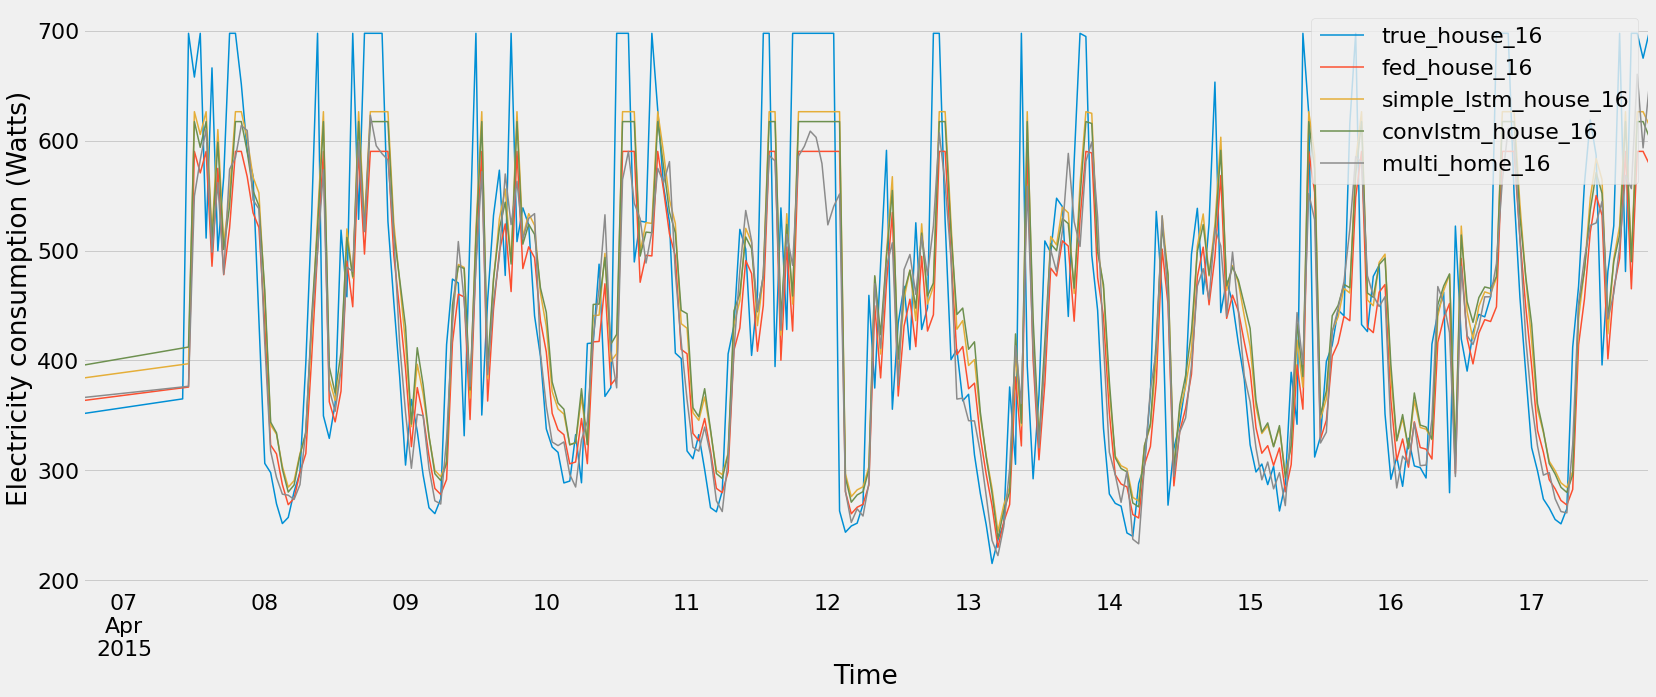

In [344]:
pred16.iloc[140:408,:].plot(lw=1.5,xlabel="Time", ylabel='Electricity consumption (Watts)', figsize=(25,10))

In [316]:
len(refit)

7248